# 09_Evaluate_on_test

Here we take the Experiment 1 models and test them on the test set data. 
It is used to generate the main figure in Experiment 1

In [1]:
!pip install pyyaml==5.1
#!pip uninstall torch
!yes | pip uninstall detectron2
#!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
    
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
 

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Found existing installation: detectron2 0.6+cu111
Uninstalling detectron2-0.6+cu111:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/detectron2-0.6+cu111.dist-info/*
    /usr/local/lib/python3.8/dist-packages/detectron2/*
    /usr/local/lib/python3.8/dist-packages/tools/*
Proceed (y/n)?   Successfully uninstalled detectron2-0.6+cu111
yes: standard output: Broken pipe
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
  Using cached https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/detectron2-0.6%2Bcu111-cp38-cp38-linux_x86_64.whl (6.9 MB)


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

import os
import sys

import json
from datetime import datetime
import random as rd
import itertools

## Function to register our datasets 
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data import DatasetMapper
from detectron2.data import DatasetCatalog

from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

from detectron2.config import get_cfg
from detectron2 import model_zoo

#dataset_name_train = "thesis_030_train"
#dataset_name_val = "thesis_030_test"

def register(name, path_labels, path_data):

    # Check if dataset name already exists in catalog
    if name in DatasetCatalog.list():
        
        # Remove existing dataset from catalog
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

    # Register your dataset using register_coco_instances
    register_coco_instances(name, {}, path_labels, path_data)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [2]:
base_path = "/workspace/scripts"

os.chdir(base_path)

# Taken from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from EvalLossHook import LossEvalHook
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

class MyTrainer(DefaultTrainer):
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        
        # add the best checkpointer hook
        # adapted from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023
        hooks.insert(-1, BestCheckpointer(self.cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                                         "bbox/AP50",
                                         "max",
                                         "best_ap50"
                                         ))
        return hooks

    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)
 


In [5]:

    
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

def evaluate_detectron(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         trial_id = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        best_model_path = None
                        ):
    
    """

    """

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
        
    register(dataset_name_train, "/workspace/data/labels_train_DT.json", f"/workspace/data/data_{resolution}/train/data")
    register(dataset_name_val, "/workspace/data/labels_test_without_mexico.json", f"/workspace/data/data_{resolution}/test/data")
    
    if output_dir_prefix:
        now = datetime.now() 
        output_dir = f"/workspace/output/{output_dir_prefix}/res{resolution}_{trial_id}"
    else:
        now = datetime.now() 
        output_dir = f"/workspace/output/res{resolution}_{now.strftime('%m.%d.%H.%M')}"
        
    # batchsize * iterations
    views = 120000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    print(cfg.OUTPUT_DIR)
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 15 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30
    
    cfg.MODEL.WEIGHTS = best_model_path

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=True)
    
    evaluator = COCOEvaluator(dataset_name_val, cfg, False, output_dir="/workspace/final_test_300",max_dets_per_image = 30)
    val_loader = build_detection_test_loader(cfg, dataset_name_val)
    
    
    
    return inference_on_dataset(trainer.model, val_loader, evaluator)



In [7]:
out = evaluate_detectron({'learning_rate': 0.001, 'batch_size': 5, 'gradient_clipping': True, 'weight_decay': 0.001, 'freeze_at': 1, 'index': 8}, 
                        resolution = '300',
                        output_dir_prefix = 'output_test_eval',
                        dataset_name_train = 'train_data',
                        dataset_name_val = 'test_data',
                        trial_id = 30,
                   best_model_path = "/workspace/output/experiment1_val_bestconf_04.15.12.54/res300_300/best_ap50.pth")



/workspace/output/output_test_eval/res300_30
[04/27 08:32:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_feature

WARNING [04/27 08:32:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 08:32:55 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/27 08:32:56 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/27 08:32:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/27 08:32:56 d2.data.build]: Using training sampler TrainingSampler
[04/27 08:32:56 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/27 08:32:56 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/27 08:32:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/27 08:32:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/27 08:32:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 08:32:57 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/27 08:32:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/27 08:32:57 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/27 08:32:57 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/27 08:32:57 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/27 08:32:57 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter

In [5]:
model_dict = {1:{'dirs':['/workspace/output/experiment1_04.09.14.12/res030_30',
             '/workspace/output/experiment1_04.09.16.31/res035_35',
             '/workspace/output/experiment1_04.09.18.58/res040_40',
             '/workspace/output/experiment1_04.09.21.23/res045_45',
             '/workspace/output/experiment1_04.09.23.50/res050_50',
             '/workspace/output/experiment1_04.10.02.03/res070_70',
             '/workspace/output/experiment1_04.10.04.16/res100_100'],
      'config': {'learning_rate': 0.001, 'batch_size': 5, 'gradient_clipping': True, 'weight_decay': 0.001, 'freeze_at': 1, 'index': 8}
     },
2:{'dirs':['/workspace/output/experiment1_04.10.12.12/res030_30', 
 '/workspace/output/experiment1_04.10.12.12/res035_35', 
 '/workspace/output/experiment1_04.10.12.12/res040_40', 
 '/workspace/output/experiment1_04.10.12.12/res045_45', 
 '/workspace/output/experiment1_04.10.12.12/res050_50', 
 '/workspace/output/experiment1_04.10.12.12/res070_70', 
 '/workspace/output/experiment1_04.10.12.12/res100_100'],
    'config':{"learning_rate": 0.01, "batch_size": 8, "gradient_clipping": False, "weight_decay": 0.0001, "freeze_at": 1, "index": 6}
    },
3: {'dirs':['/workspace/output/experiment1_val_conf3_04.14.15.43/res030_30', '/workspace/output/experiment1_val_conf3_04.14.15.43/res035_35', '/workspace/output/experiment1_val_conf3_04.14.15.43/res040_40', '/workspace/output/experiment1_val_conf3_04.14.15.43/res045_45', '/workspace/output/experiment1_val_conf3_04.14.15.43/res050_50', '/workspace/output/experiment1_val_conf3_04.14.15.43/res070_70', '/workspace/output/experiment1_val_conf3_04.14.15.43/res100_100'],
      'config':{'learning_rate': 0.001, 'batch_size': 8, 'gradient_clipping': False, 'weight_decay': 0.001, 'freeze_at': 2, 'index': 13}
}}



In [6]:
## This is the evaluation on the test set without Mexico. 

for i in range(3):
    config = i+1

    ap50_test = []

    for r, res in zip(model_dict[config]['dirs'], ['030', '035', '040', '045', '050', '070', '100']):
        aps = evaluate_detectron(model_dict[config]['config'], 
                            resolution = res,
                            output_dir_prefix = 'output_test_eval',
                            dataset_name_train = 'train_data',
                            dataset_name_val = 'test_data',
                            trial_id = config,
                       best_model_path = f"{r}/best_ap50.pth")

        ap50_test.append(aps['bbox']['AP50'])

    model_dict[config]['test_AP50'] = ap50_test

    print(ap50_test)
with open(f'test_set_evals_noMexico_22.4.10.10.json', 'w') as f:
        json.dump(model_dict, f)

/workspace/output/output_test_eval/res030_1
[04/25 08:12:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features

WARNING [04/25 08:12:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:12:12 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:12:13 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:12:13 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|     DT     | 53154        |
|            |              |
[04/25 08:12:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:12:13 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:12:13 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:12:13 d2.data.common]: Serialized dataset tak

WARNING [04/25 08:12:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:12:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:12:15 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:12:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:12:15 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:12:15 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:12:15 d2.evaluation.evaluator]: Start inference on 1658 batches


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[04/25 08:12:16 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0363 s/iter. Eval: 0.0002 s/iter. Total: 0.0372 s/iter. ETA=0:01:01
[04/25 08:12:21 d2.evaluation.evaluator]: Inference done 154/1658. Dataloading: 0.0008 s/iter. Inference: 0.0342 s/iter. Eval: 0.0002 s/iter. Total: 0.0352 s/iter. ETA=0:00:52
[04/25 08:12:26 d2.evaluation.evaluator]: Inference done 297/1658. Dataloading: 0.0008 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0351 s/iter. ETA=0:00:47
[04/25 08:12:31 d2.evaluation.evaluator]: Inference done 438/1658. Dataloading: 0.0009 s/iter. Inference: 0.0342 s/iter. Eval: 0.0001 s/iter. Total: 0.0352 s/iter. ETA=0:00:43
[04/25 08:12:36 d2.evaluation.evaluator]: Inference done 575/1658. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0001 s/iter. Total: 0.0356 s/iter. ETA=0:00:38
[04/25 08:12:41 d2.evaluation.evaluator]: Inference done 719/1658. Dataloading: 0.0009 s/iter. Inference: 0.0344 s/iter. 

WARNING [04/25 08:13:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:13:19 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:13:19 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:13:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:13:20 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:13:20 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:13:20 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:13:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:13:20 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:13:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:13:20 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:13:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:13:20 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:13:20 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:13:20 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:13:21 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0367 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:14:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:14:23 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:14:23 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:14:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:14:24 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:14:24 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:14:24 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:14:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:14:24 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:14:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:14:24 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:14:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:14:24 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:14:24 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:14:24 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:14:25 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0337 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:15:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:15:27 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:15:27 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:15:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:15:28 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:15:28 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:15:28 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:15:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:15:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:15:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:15:28 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:15:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:15:29 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:15:29 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:15:29 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:15:29 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:16:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:16:31 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:16:31 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:16:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:16:31 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:16:31 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:16:31 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:16:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:16:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:16:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:16:32 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:16:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:16:32 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:16:32 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:16:32 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:16:33 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:18:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:18:40 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:18:40 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:18:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:18:40 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:18:40 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:18:41 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:18:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:18:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:18:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:18:41 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:18:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:18:41 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:18:41 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:18:41 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:18:42 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0341 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:19:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:19:46 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:19:46 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:19:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:19:46 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:19:46 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:19:46 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:19:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:19:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:19:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:19:47 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:19:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:19:47 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:19:47 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:19:47 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:19:48 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:20:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:20:51 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:20:51 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:20:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:20:51 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:20:51 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:20:51 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:20:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:20:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:20:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:20:52 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:20:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:20:52 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:20:52 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:20:52 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:20:53 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0340 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:21:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:21:56 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:21:56 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:21:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:21:57 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:21:57 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:21:57 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:21:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:21:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:21:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:21:57 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:21:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:21:57 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:21:57 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:21:57 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:21:58 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter

WARNING [04/25 08:23:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:23:01 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:23:02 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:23:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:23:02 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:23:02 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:23:02 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:23:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:23:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:23:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:23:03 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:23:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:23:03 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:23:03 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:23:03 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:23:03 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:24:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:24:07 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:24:07 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:24:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:24:08 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:24:08 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:24:08 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:24:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:24:08 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:24:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:24:08 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:24:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:24:08 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:24:08 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:24:08 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:24:09 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0008 s/iter. Inference: 0.0340 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:25:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:25:13 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:25:13 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:25:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:25:14 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:25:14 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:25:14 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:25:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:25:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:25:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:25:14 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:25:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:25:14 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:25:14 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:25:14 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:25:15 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:26:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:26:19 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:26:20 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:26:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:26:20 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:26:20 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:26:20 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:26:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:26:21 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:26:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:26:21 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:26:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:26:21 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:26:21 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:26:21 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:26:21 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0342 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:27:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:27:25 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:27:26 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:27:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:27:26 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:27:26 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:27:26 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:27:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:27:27 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:27:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:27:27 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:27:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:27:27 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:27:27 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:27:27 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:27:27 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0340 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:28:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:28:30 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:28:30 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:28:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:28:31 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:28:31 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:28:31 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:28:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:28:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:28:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:28:31 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:28:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:28:31 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:28:31 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:28:31 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:28:32 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0346 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:29:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:29:35 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:29:35 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:29:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:29:35 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:29:35 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:29:35 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:29:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:29:36 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:29:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:29:36 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:29:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:29:36 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:29:36 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:29:36 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:29:37 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0367 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:30:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:30:40 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:30:41 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:30:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:30:41 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:30:41 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:30:41 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:30:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:30:42 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:30:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:30:42 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:30:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:30:42 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:30:42 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:30:42 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:30:42 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0009 s/iter. Inference: 0.0361 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:31:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:31:46 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:31:46 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:31:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:31:46 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:31:46 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:31:46 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:31:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:31:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:31:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:31:47 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:31:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:31:47 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:31:47 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:31:47 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:31:47 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0346 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:32:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:32:51 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:32:51 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:32:52 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:32:52 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:32:52 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:32:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:32:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:32:53 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:32:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:32:53 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:32:53 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:32:53 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:32:53 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter

WARNING [04/25 08:33:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:33:57 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_train_DT.json
[04/25 08:33:57 d2.data.build]: Removed 848 images with no usable annotations. 10848 images left.
[04/25 08:33:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/25 08:33:58 d2.data.build]: Using training sampler TrainingSampler
[04/25 08:33:58 d2.data.common]: Serializing 10848 elements to byte tensors and concatenating them all ...
[04/25 08:33:58 d2.data.common]: Serialized dataset takes 5.53 MiB
[04/25 08:33:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='ch

WARNING [04/25 08:33:58 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/25 08:33:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/25 08:33:58 d2.data.datasets.coco]: Loaded 1658 images in COCO format from /workspace/data/labels_test_without_mexico.json
[04/25 08:33:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/25 08:33:58 d2.data.common]: Serializing 1658 elements to byte tensors and concatenating them all ...
[04/25 08:33:58 d2.data.common]: Serialized dataset takes 0.75 MiB
[04/25 08:33:58 d2.evaluation.evaluator]: Start inference on 1658 batches
[04/25 08:33:59 d2.evaluation.evaluator]: Inference done 11/1658. Dataloading: 0.0007 s/iter. Inference: 0.0363 s/iter. Eval: 0.0002 s/iter

## Results for full test set saved in 'test_set_evals_15.4.18.23.json'

In [8]:
model_dict

{1: {'dirs': ['/workspace/output/experiment1_04.09.14.12/res030_30',
   '/workspace/output/experiment1_04.09.16.31/res035_35',
   '/workspace/output/experiment1_04.09.18.58/res040_40',
   '/workspace/output/experiment1_04.09.21.23/res045_45',
   '/workspace/output/experiment1_04.09.23.50/res050_50',
   '/workspace/output/experiment1_04.10.02.03/res070_70',
   '/workspace/output/experiment1_04.10.04.16/res100_100'],
  'config': {'learning_rate': 0.001,
   'batch_size': 5,
   'gradient_clipping': True,
   'weight_decay': 0.001,
   'freeze_at': 1,
   'index': 8},
  'test_AP50': [39.44621831833062,
   35.897442959053386,
   33.32763439654063,
   31.661137438384614,
   25.871155632302074,
   25.77344387509568,
   15.233010195811048]},
 2: {'dirs': ['/workspace/output/experiment1_04.10.12.12/res030_30',
   '/workspace/output/experiment1_04.10.12.12/res035_35',
   '/workspace/output/experiment1_04.10.12.12/res040_40',
   '/workspace/output/experiment1_04.10.12.12/res045_45',
   '/workspace/ou

## Plotting for main results figure in main experiment. 

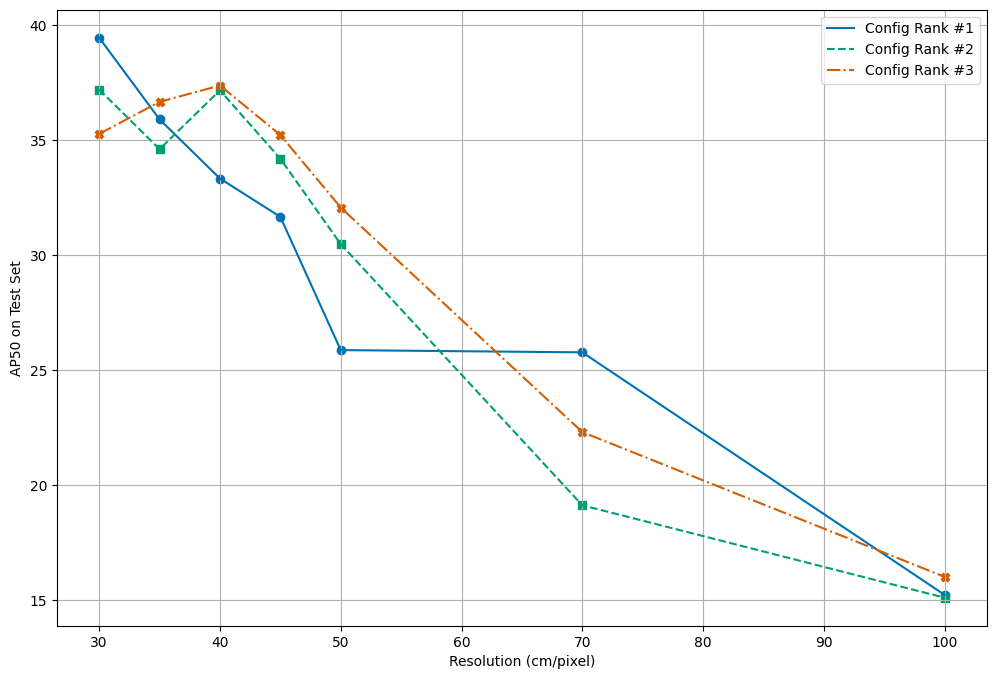

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-colorblind")

res = [30, 35, 40, 45, 50, 70, 100]
x = []
y = []

lty = ['-','--','-.']
mkr = ['o','s','X']

plt.figure(figsize = (12,8))
for i in range(3):
    x.append(res)
    y.append(model_dict[i+1]['test_AP50'])
    
    #color = cmap((i+1) / 3)
    plt.scatter(res,model_dict[i+1]['test_AP50'],
               marker = mkr[i%3])
    plt.plot(res, model_dict[i+1]['test_AP50'], 
             label = f"Config Rank #{i+1}", 
             #color = color,
            linestyle = lty[i%3])
 
# In case you want a trendline
# x = np.array(x).flatten()
# y = np.array(y).flatten()
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# plt.plot(x, p(x), color = 'red')
    
plt.xlabel("Resolution (cm/pixel)")
plt.ylabel("AP50 on Test Set")
plt.legend()
plt.grid()
plt.savefig('/workspace/figures/res_ap50_testset', pad_inches =0, bbox_inches = 0)
plt.show()